In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import sys
sys.path.append("../plenoxels")
# from plenoxels.simple_tree import init_render_opt, VolumeRenderFunction, Octree
from tc_plenoptimize import init_datasets, init_profiler, parse_config
import config
import matplotlib.pyplot as plt
import math

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
cfg = config.get_cfg_defaults()
dev = "cuda"

In [5]:
def plot_ts(ts_dset, tree, use_ext, batch_size=10_000):
    with torch.autograd.no_grad():
        for ts_el in ts_dset:
            rays, rgb = ts_el
            rgb = rgb.view(ts_dset.img_h, ts_dset.img_w, 3)
            preds = []
            for b in range(math.ceil(rays.shape[0] / batch_size)):
                rays_o = rays[b * batch_size: (b + 1) * batch_size, 0].to("cuda")
                rays_d = rays[b * batch_size: (b + 1) * batch_size, 1].to("cuda")
                preds.append(tree(rays_o, rays_d, use_ext).cpu())
            pred = torch.cat(preds, 0).view(ts_dset.img_h, ts_dset.img_w, 3)
            break
    fig, ax = plt.subplots()
    ax.imshow(pred)

### Invocation sample for old octree

In [ ]:
tree = Octree(max_internal_nodes=1, initial_levels=1, 
              sh_degree=2, render_opt=init_render_opt(),
              branching=2,
              radius=(tr_dset.scene_bbox[1] - tr_dset.scene_bbox[0]) / 2,
              center=(tr_dset.scene_bbox[1] + tr_dset.scene_bbox[0]) / 2,
              parent_sum=True, dtype=torch.float32).cuda()
with torch.autograd.no_grad():
    tree.data[..., :-1].fill_(0.005)  # RGB
    tree.data[..., -1].fill_(0.05)    # Density

## Corner Tree

Initialize like:
```
t = CornerTree(sh_degree=1, init_internal=585, 
               aabb=torch.tensor([[-1.3, -1.3, -1.3], [1.3, 1.3, 1.3]]), near=2., far=6.,
               init_rgb=0.01, init_sigma=0.1)
t.refine()
t.refine()
t.refine()
t.refine()
```

In [6]:
_corner_tree_max_side = 256
def enc_pos(coo):
    return (coo[:, 0] * (_corner_tree_max_side ** 3) + 
            coo[:, 1] * (_corner_tree_max_side ** 2) + 
            coo[:, 2] * _corner_tree_max_side).long()

In [126]:
from plenoxels.tc_plenoxel import plenoxel_sh_encoder


class CornerTree(torch.nn.Module):
    def __init__(self, 
                 sh_degree: int,
                 init_internal: int, 
                 aabb: torch.Tensor, 
                 near: float, 
                 far: float,
                 init_rgb: float,
                 init_sigma: float):
        super().__init__()
        self.data_dim = 3 * (sh_degree + 1) ** 2 + 1
        # TODO: near and far should be transformed
        self.near = near
        self.far = far
        # 1 / diameter
        scaling = 1 / (aabb[1] - aabb[0])
        # 0.5 - center / diameter
        offset = 0.5 - 0.5 * (aabb[0] + aabb[1]) * scaling
        self.num_samples = 128
        self.white_bkgd = True
        self.init_rgb = init_rgb
        self.init_sigma = init_sigma
        self.sh_encoder = plenoxel_sh_encoder(sh_degree)
        
        child    = torch.empty(init_internal, 2, 2, 2, dtype=torch.long)
        coords   = torch.empty(init_internal, 2, 2, 2, 3)
        nids     = torch.empty(init_internal, 2, 2, 2, 8, dtype=torch.long)
        depths   = torch.empty(init_internal, dtype=torch.long)
        is_child_leaf = torch.ones(init_internal, 2, 2, 2, dtype=torch.bool)
        self.data = torch.nn.EmbeddingBag(1, self.data_dim, mode='sum')           # n_data, data_dim
        
        offsets_3d = torch.tensor([[-1, -1, -1], [-1, -1, 1], [-1, 1, -1], [-1, 1, 1],
                                   [1, -1, -1], [1, -1, 1], [1, 1, -1], [1, 1, 1]])
        self.register_buffer("offset", offset)
        self.register_buffer("scaling", scaling)
        self.register_buffer("aabb", aabb)
        self.register_buffer("offsets_3d", offsets_3d)
        self.register_buffer("child", child)
        self.register_buffer("coords", coords)
        self.register_buffer("nids", nids)
        self.register_buffer("depths", depths)
        self.register_buffer("is_child_leaf", is_child_leaf)
        self.register_buffer("ucoo", torch.tensor([]))
        self.n_internal = 0
        
    def trasform_coords(self, coords):
        """From world-coordinates to tree-coordinates (a cube between 0 and 1)"""
        return self.offset + coords * self.scaling

    @torch.no_grad()
    def refine(self, leaves=None):
        # 1. figure out the coordinates of the leaves. This is non-trivial, likely requires traeversing the tree.
        # 2. split the leaves. Add child, is_child_leaf, parent, depth.

        # 3. For each new leaf calculate coordinates of its neighbors.
        # 4. encode neighbor coordinates, and append to existing coordinates
        # 5. Unique with inverse.
        # 6. Run whatever is below
        if leaves is None:
            leaves = self.is_child_leaf[:self.n_internal].nonzero(as_tuple=False)  # n_leaves, 4
        sel = (leaves[:, 0], leaves[:, 1], leaves[:, 2], leaves[:, 3])
        
        n_int = self.n_internal
        n_nodes = self.n_internal * 8 + 1
        n_int_new = leaves.shape[0] if n_int > 0 else 1
        n_nodes_fin = n_nodes + n_int_new * 8
        print(f"{n_int=}, {n_nodes=}, {n_int_new=}, {n_nodes_fin=}")
        if n_int_new + n_int > self.child.shape[0]:
            raise RuntimeError(f"Not enough data-space for refinement. "
                               f"Need {n_int_new + n_int}, Have {self.child.shape[0]}")

        leaf_coo = self.coords[sel] if n_int > 0 else torch.tensor([[0.5, 0.5, 0.5]])
        depths = self.depths[sel[0]] if n_int > 0 else torch.tensor([0])
        # + 1 since it's the new leaf, and +1 to get half-voxel-size
        new_leaf_sizes = (1 / (2 ** (depths + 2))).unsqueeze(-1).unsqueeze(-1)
        
        n_offsets = self.offsets_3d.unsqueeze(0).repeat(n_int_new, 1, 1) * new_leaf_sizes  # [nl, 8, 3]
        new_child = (
            torch.arange(n_nodes, n_nodes_fin, dtype=torch.int32).view(-1, 2, 2, 2)
            - torch.arange(n_int, n_int + n_int_new).view(-1, 1, 1, 1)
        )
        self.child[n_int: n_int + n_int_new] = new_child
        self.is_child_leaf[sel] = False
        
        new_leaf_coo = leaf_coo.unsqueeze(1) + n_offsets  # [nl, 8, 3]
        self.coords[n_int: n_int + n_int_new] = new_leaf_coo.view(-1, 2, 2, 2, 3)
        self.depths[n_int: n_int + n_int_new] = depths + 1
        
        self.n_internal = n_int + n_int_new
        
        # From leaf center to corners (nl -> 8*nl=nc)
        new_corners = (new_leaf_coo.view(-1, 1, 3) + n_offsets.repeat_interleave(8, dim=0)).view(-1, 3)
        new_corners_enc = enc_pos(new_corners)
        # Need to get all the encoded corner positions of the whole tree.
        if n_int > 0:
            corners_enc = torch.cat((self.ucoo[self.nids[:n_int].view(-1)], new_corners_enc))
        else:
            corners_enc = new_corners_enc
        
        new_u_cor, new_cor_idx = torch.unique(corners_enc, return_inverse=True, sorted=True)
        print(f"Deduped corner coordinates from {corners_enc.shape[0]} to {new_u_cor.shape[0]}")
        
        # Update the tree-data: create new tensor, copy the old data into it (with changed indices).
        new_data = torch.zeros(new_u_cor.shape[0], self.data_dim)
        new_data[:, :-1].fill_(self.init_rgb)
        new_data[:, -1].fill_(self.init_sigma)
        if n_int > 0:
            new_data[torch.searchsorted(new_u_cor, self.ucoo), :] = self.data.weight
        self.data = torch.nn.EmbeddingBag.from_pretrained(new_data, freeze=False, mode='sum', sparse=False)
        self.ucoo = new_u_cor
        # TODO: parent data should be copied into the corresponding children

        # New neighbor indices
        self.nids[:n_int + n_int_new] = new_cor_idx.view(-1, 2, 2, 2, 8)
        
    def query(self, indices):
        n = indices.shape[0]

        with torch.autograd.no_grad():
            indices = self.trasform_coords(indices)
            node_ids = torch.zeros(n, dtype=torch.long, device=indices.device)
            remain_indices = torch.arange(n, dtype=torch.long, device=indices.device)
            floor_indices = torch.zeros(n, 3, dtype=torch.float, device=indices.device)
            xy = indices
            while remain_indices.numel():
                xy *= 2
                floor = torch.floor(xy)
                floor.clamp_max_(1)
                xy -= floor
                sel = (node_ids[remain_indices], *(floor.long().T),)
                deltas = self.child[sel]

                term_mask = self.is_child_leaf[sel]  # terminate when nodes with 0 children encountered (leaves).
                term_indices = remain_indices[term_mask]

                indices.scatter_(0, term_indices.unsqueeze(-1).repeat(1, 3), xy[term_mask])
                floor_indices.scatter_(0, term_indices.unsqueeze(-1).repeat(1, 3), floor[term_mask])
                
                remain_indices = remain_indices[~term_mask]
                if not remain_indices.numel():
                    break
                
                node_ids[remain_indices] += deltas
                xy = xy[~term_mask]
                floor = floor[~term_mask]

        xy = indices
        sel = (node_ids, *(floor_indices.long().T),)
        sel_nids = self.nids[sel]  # n, 8
        weights = torch.stack((
            (1 - xy[:, 0]) * (1 - xy[:, 1]) * (1 - xy[:, 2]),
            (1 - xy[:, 0]) * (1 - xy[:, 1]) * (xy[:, 2]),
            (1 - xy[:, 0]) * (xy[:, 1])     * (1 - xy[:, 2]),
            (1 - xy[:, 0]) * (xy[:, 1])     * (xy[:, 2]),
            (xy[:, 0])     * (1 - xy[:, 1]) * (1 - xy[:, 2]),
            (xy[:, 0])     * (1 - xy[:, 1]) * (xy[:, 2]),
            (xy[:, 0])     * (xy[:, 1])     * (1 - xy[:, 2]),
            (xy[:, 0])     * (xy[:, 1])     * (xy[:, 2]),
        ), dim=1)  # n, 8
        return self.data(sel_nids, per_sample_weights=weights)
    
    @torch.no_grad()
    def sample_proposal(self, rays_o, rays_d, max_samples):
#         rays_o = self.trasform_coords(rays_o)
        # scale direction
        rays_d.mul_(self.scaling)
        delta_scale = 1 / torch.linalg.norm(rays_d, dim=1, keepdim=True)
        rays_d.mul_(delta_scale)
        step_size = 1 / max_samples
        
        offsets_pos = (self.aabb[1] - rays_o) / rays_d  # [batch, 3]
        offsets_neg = (self.aabb[0] - rays_o) / rays_d  # [batch, 3]
        offsets_in = torch.minimum(offsets_pos, offsets_neg)  # [batch, 3]
        start = torch.amax(offsets_in, dim=-1, keepdim=True)  # [batch, 1]
#         start.clamp_(min=self.near, max=self.far)  # [batch, 1]
        steps = torch.arange(max_samples, dtype=torch.float32, device=self.child.device).unsqueeze(0)  # [1, n_intrs]
        steps = steps.repeat(rays_d.shape[0], 1)   # [batch, n_intrs]
        intersections = start + steps * step_size  # [batch, n_intrs]
        dts = torch.diff(intersections, n=1, dim=1).mul(delta_scale)
        intersections = intersections[:, :-1]
        points = rays_o.unsqueeze(1) + intersections.unsqueeze(2) * rays_d.unsqueeze(1)
        points_valid = ((points > self.aabb[0]) & (points < self.aabb[1])).all(-1)
        return points, dts, points_valid
    
    def forward(self, rays_o, rays_d):
        # NOTE: sample_proposal modifies rays_d.
        pts, dt, valid = self.sample_proposal(rays_o, rays_d, self.num_samples)
        batch, nintrs = pts.shape[:2]
        
        interp_masked = self.query(pts[valid].view(-1, 3))
        interp = torch.zeros(batch, nintrs, self.data_dim, 
                             dtype=torch.float32, device=interp_masked.device)
        interp.masked_scatter_(valid.unsqueeze(-1), interp_masked)
        
        sh_mult = self.sh_encoder(rays_d)  # [batch, ch/3]
        sh_mult = sh_mult.unsqueeze(1).expand(batch, nintrs, -1).unsqueeze(2)  # [batch, nintrs, 1, ch/3]
        interp_rgb = interp[..., :-1].view(batch, nintrs, 3, sh_mult.shape[-1])  # [batch, nintrs, 3, ch/3]
        rgb = torch.sum(sh_mult * interp_rgb, dim=-1)  # [batch, nintrs, 3]
        
        sigma = interp[..., -1]  # [batch, n_intrs-1, 1]
        
        # Volumetric rendering
        alpha = 1 - torch.exp(-torch.relu(sigma) * dt)            # alpha: [batch, n_intrs-1]
        cum_light = torch.cat((torch.ones(rgb.shape[0], 1, dtype=rgb.dtype, device=rgb.device),
                               torch.cumprod(1 - alpha[:, :-1] + 1e-10, dim=-1)), dim=-1)  # [batch, n_intrs-1]
        abs_light = alpha * cum_light  # [batch, n_intersections - 1]
        acc_map = abs_light.sum(-1)    # [batch]

        # Accumulated color over the samples, ignoring background
        rgb = torch.sigmoid(rgb)  # [batch, n_intrs-1, 3]
        rgb_map = (abs_light.unsqueeze(-1) * rgb).sum(dim=-2)  # [batch, 3]

        if self.white_bkgd:
            # Including the white background in the final color
            rgb_map = rgb_map + (1. - acc_map.unsqueeze(1))

        return rgb_map

## Test Learning

In [39]:
cfg.optim.batch_size = 4000
cfg.data.max_tr_frames = None

In [40]:
tr_dset, tr_loader, ts_dset = init_datasets(cfg, dev)

Loading test data: 100%|██████████| 2/2 [00:00<00:00, 23.15it/s]


In [41]:
data_iter = iter(tr_loader)

In [126]:
from plenoxels.corner_tree import CornerTree

In [127]:
tree = CornerTree(sh_degree=2, init_internal=37449, 
                  aabb=tr_dset.scene_bbox, near=2., far=6.,
                  init_rgb=0.01, init_sigma=0.1)
tree.refine()
tree.refine()
tree.refine()
tree.refine()
tree.refine()
tree.refine()
with torch.no_grad():
    torch.nn.init.uniform_(tree.data.weight, 0.0, 0.1)
tree.cuda()

n_int=0, n_nodes=1, n_int_new=1, n_nodes_fin=9
Deduped corner coordinates from 64 to 27
n_int=1, n_nodes=9, n_int_new=8, n_nodes_fin=73
Deduped corner coordinates from 576 to 125
n_int=9, n_nodes=73, n_int_new=64, n_nodes_fin=585
Deduped corner coordinates from 4672 to 729
n_int=73, n_nodes=585, n_int_new=512, n_nodes_fin=4681
Deduped corner coordinates from 37440 to 4913
n_int=585, n_nodes=4681, n_int_new=4096, n_nodes_fin=37449
Deduped corner coordinates from 299584 to 35937
n_int=4681, n_nodes=37449, n_int_new=32768, n_nodes_fin=299593
Deduped corner coordinates from 2396736 to 274625


CornerTree(
  (data): EmbeddingBag(274625, 28, mode=sum)
)

### Test components

In [82]:
rays, imgs = next(data_iter)
imgs = imgs.to(device=dev)
rays_o = rays[:, 0].contiguous().to(device=dev)
rays_d = rays[:, 1].contiguous().to(device=dev)
rays_d /= torch.linalg.norm(rays_d, dim=1, keepdim=True)

preds_p = tree(rays_o, rays_d, use_ext=False)
preds_c = tree(rays_o, rays_d, use_ext=True)

In [83]:
t_o = tree.trasform_coords(rays_o)
pts_p = preds_p[1]
valid_p = preds_p[3]
pts_c = t_o.unsqueeze(1) + preds_c.ray_offsets.unsqueeze(-1) * rays_d.unsqueeze(1)
# print("ray_o", t_o)
# print("ray_d", rays_d, torch.linalg.norm(rays_d[0]))

In [89]:
# interpolation weights
w_p_ = preds_p[4]
w_c = preds_c.interpolation_weights
w_p = torch.zeros_like(w_c)
w_p.masked_scatter_(valid_p.unsqueeze(-1).repeat(1, 1, 8), w_p_);
((w_p - w_c).abs().sum(-1) > 1e-4).nonzero()

tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)

In [90]:
# interpolation outputs
ival_c = preds_c.interpolated_vals
ival_p = preds_p[5]
((ival_p[0, 0] - ival_c[0, 0]).abs() > 1e-5).nonzero()

tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)

In [91]:
# Outputs
out_c = preds_c.output_rgb
out_p = preds_p[0]
((out_c - out_p).abs() > 1e-5).nonzero()

tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)

In [96]:
cube_sz = 32
def s_aabb(pos, invdir):
    pos = pos.clone()
    fs = []
    for i in range(5):
        pos *= 2
        f = torch.floor(pos)
        pos -= f
        fs.append(f)
    f = torch.cat(fs, 0).cpu()
    f = (f * (2 ** torch.arange(f.shape[0]))).sum()
#     t1 = (1 - pos) * invdir
#     t2 = (- pos) * invdir
    t1 = -pos * invdir
    t2 = t1 + invdir
    tmin = torch.max(torch.minimum(t1, t2))
    tmax = torch.min(torch.maximum(t1, t2))
#     print("Subcube tmin=%.3f - tmax=%.3f - f-pos %d" % (
#         tmin.item(), tmax.item(), int(f)))
    return tmin, tmax
    
def sample_proposal(ray_o_norm, ray_d):
    invdir = 1 / (ray_d + 1e-8)
    
    t1 = -ray_o_norm * invdir
    t2 = t1 + invdir
    tmin = torch.max(torch.minimum(t1, t2))
    tmax = torch.min(torch.maximum(t1, t2))
    
    t = tmin
    print(tmin)
    dt = 0
    n_samples_left = 0
    
    
    while t < tmax:
        
        print("Point is at", ray_o_norm + t * ray_d)
#         s_tmin, s_tmax = s_aabb(ray_o_norm + t * ray_d, invdir)
#         s_aabb(ray_o_norm + t * ray_d, invdir)
#         print(f"{n_samples_left=} {t.item()=:.4f} {dt=}")
        if n_samples_left == 0:
#             print("---Recomputing---")
            t += dt / 2 + 1e-4
    
            relpos = ray_o_norm + t * ray_d
            s_tmin, s_tmax = s_aabb(relpos, invdir)
            s_size = (s_tmax - s_tmin) / cube_sz
            print(s_size)
            n_samples_left = math.ceil(1 * s_size * cube_sz / 1.732)
            dt = s_size / n_samples_left
            t += s_tmin / cube_sz + dt / 2
#             print(f"---Recompute finished: t={t.item():.3f} dt={dt.item():.4f} samples_left={n_samples_left}---")
            
        else:
            t += dt
        n_samples_left -= 1
    print(tmax)

In [52]:
pts_p[8, 0], torch.floor(pts_c[8, 0])

(tensor([-5.9605e-08,  2.4792e-01,  2.9169e-01], device='cuda:0'),
 tensor([-1.,  0.,  0.], device='cuda:0'))

In [50]:
w_p[8, 0], w_c[8, 0]

(tensor([1.6802e-07, 3.3867e-07, 1.0969e-06, 2.2111e-06, 4.4044e-02, 8.8781e-02,
         2.8755e-01, 5.7962e-01], device='cuda:0'),
 tensor([0.0440, 0.0888, 0.2876, 0.5796, 0.0000, 0.0000, 0.0000, 0.0000],
        device='cuda:0'))

### Test the training process

In [128]:
optim = torch.optim.SGD(params=tree.parameters(), lr=1e6)

In [129]:
dev = "cuda"

In [130]:
for i in range(300):
    rays, imgs = next(data_iter)
    imgs = imgs.to(device=dev)
    rays_o = rays[:, 0].contiguous().to(device=dev)
    rays_d = rays[:, 1].contiguous().to(device=dev)
    rays_d /= torch.linalg.norm(rays_d, dim=1, keepdim=True)
    preds = tree(rays_o, rays_d, use_ext=True)
    loss = F.mse_loss(preds, imgs)
    optim.zero_grad()
    loss.backward()
    print(loss)
    optim.step()

tensor(0.0960, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1105, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0902, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0735, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0628, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0522, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0477, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0415, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0227, device='cuda:0', grad_fn=

tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=

tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=

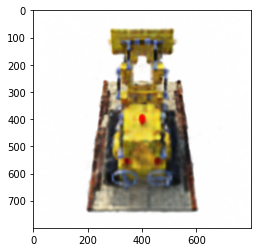

In [131]:
plot_ts(ts_dset, tree, use_ext=True, batch_size=10000)

## Test simple tree

In [4]:
tree = Octree(max_internal_nodes=1, initial_levels=1, 
              sh_degree=1, render_opt=init_render_opt(),
              branching=2, radius=None, center=None,
              parent_sum=True, dtype=torch.float32).cuda()

In [21]:
tree.data[:, :3]

tensor([[ 12.,  12.,  12.],
        [-11., -11., -11.],
        [-11., -11., -10.],
        [-11., -10., -11.],
        [-11., -10., -10.],
        [-10., -11., -11.],
        [-10., -11., -10.],
        [-10., -10., -11.],
        [-10., -10., -10.]], device='cuda:0', grad_fn=<SliceBackward0>)

In [19]:
 tree.query_interp(torch.tensor([[0.25, 0.75, 0.75]]).cuda())

(tensor([[10.8032, 10.8882, 10.8882,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0'),
 tensor([[0.0850, 0.1700, 0.1700, 0.3398, 0.0262, 0.0523, 0.0523, 0.1045]],
        device='cuda:0'),
 tensor([[ 4, -1, -1, -1,  8, -1, -1, -1]], device='cuda:0'))

In [10]:
with torch.autograd.no_grad():
    indices = torch.tensor([[0.25, 0.25, 0.25],
                            [0.25, 0.25, 0.75],
                            [0.25, 0.75, 0.25],
                            [0.25, 0.75, 0.75],
                            [0.75, 0.25, 0.25],
                            [0.75, 0.25, 0.75],
                            [0.75, 0.75, 0.25],
                            [0.75, 0.75, 0.75]]).cuda()
    values = torch.tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).float().cuda()
    tree.set(indices, values, True)

In [7]:
tree[0], tree[1], tree[2], tree[3], tree[4], tree[5], tree[6], tree[7]

(N3TreeView(tensor([1., 1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 1., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 2., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 2., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 1., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 2., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 2., 2.], device='cuda:0', grad_fn=<SelectBackward0>)))

In [8]:
tree._all_leaves()

tensor([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1]])

In [9]:
sel = (*tree._all_leaves()[:1].T,)
print(sel)
tree.refine(sel=sel)

(tensor([0]), tensor([0]), tensor([0]), tensor([0]))


True

In [10]:
tree.data

Parameter containing:
tensor([[[[[1., 1., 1.],
           [1., 1., 2.]],

          [[1., 2., 1.],
           [1., 2., 2.]]],


         [[[2., 1., 1.],
           [2., 1., 2.]],

          [[2., 2., 1.],
           [2., 2., 2.]]]],



        [[[[0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.]]],


         [[[0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.]]]]], device='cuda:0', requires_grad=True)

In [17]:
q_indices = torch.tensor([
    [0.125, 0.125, 0.125],
    [0.125, 0.125, 0.375],
    [0.125, 0.375, 0.125],
    [0.125, 0.375, 0.375],
    [0.375, 0.125, 0.125],
    [0.375, 0.125, 0.375],
    [0.375, 0.375, 0.125],
    [0.375, 0.375, 0.375],
    
    [0.125, 0.65, 0.125],
    [0.125, 0.55, 0.125],
    [0.125, 0.51, 0.125],
    [0.125, 0.50, 0.125],
    [0.125, 0.49, 0.125],
    [0.125, 0.45, 0.125],
    [0.125, 0.39, 0.125],
    
    [0.25, 0.25, 0.75],
    [0.25, 0.75, 0.25],
    [0.25, 0.75, 0.75],
    [0.75, 0.25, 0.25],
    [0.75, 0.25, 0.75],
    [0.75, 0.75, 0.25],
    [0.75, 0.75, 0.75]
]).cuda()
out = C_.query_interp(tree._spec(world=True), q_indices)
out

tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [0.5625, 1.0125, 0.5625],
        [0.5625, 0.9000, 0.5625],
        [0.5625, 0.8550, 0.5625],
        [0.5625, 0.8438, 0.5625],
        [0.5400, 0.5400, 0.5400],
        [0.7000, 0.7000, 0.7000],
        [0.9400, 0.9400, 0.9400],
        [1.0000, 1.0000, 2.0000],
        [1.0000, 2.0000, 1.0000],
        [1.0000, 2.0000, 2.0000],
        [2.0000, 1.0000, 1.0000],
        [2.0000, 1.0000, 2.0000],
        [2.0000, 2.0000, 1.0000],
        [2.0000, 2.0000, 2.0000]], device='cuda:0')

In [16]:
q_indices = torch.tensor([[0.26, 0.75, 0.26], [0.8, 0.8, 0.8]]).cuda()
C_.query_interp(tree._spec(world=True), q_indices[0:1])

tensor([[1.0200, 2.0000, 1.0200]], device='cuda:0')

In [27]:
tree[0], tree[1], tree[2], tree[3], tree[4], tree[5], tree[6], tree[7], tree[8]

(N3TreeView(tensor([1., 1., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 2., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 2., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 1., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 2., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([2., 2., 2.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([1., 1., 1.], device='cuda:0', grad_fn=<SelectBackward0>)))

In [28]:
tree._all_leaves().shape

torch.Size([15, 4])

In [27]:
indices = torch.tensor([[0.0, 0.0, 0.0], [1., 1., 1.]]).cuda()
values = torch.tensor([[3, 3, 3], [6, 6, 100000]]).float()
tree.set(indices, values)

In [25]:
tree[0], tree[1], tree[2], tree[3], tree[4], tree[5], tree[6], tree[7]

(N3TreeView(tensor([3., 3., 3.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([6.0000e+00, 6.0000e+00, 1.0000e+05], device='cuda:0',
        grad_fn=<SelectBackward0>)))

(N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)),
 N3TreeView(tensor([6.0000e+00, 6.0000e+00, 1.0000e+05], device='cuda:0',
        grad_fn=<SelectBackward0>)))

In [13]:
q_indices = torch.tensor([[0.26, 0.75, 0.26], [0.8, 0.8, 0.8]]).cuda()
C_.query_interp(tree._spec(world=True), q_indices[0:1])

tensor([[2.4000e-03, 2.4000e-03, 4.0000e+01]], device='cuda:0')

In [19]:
C_.query_vertical(tree._spec(world=True), indices)

(tensor([[3.0000e+00, 3.0000e+00, 3.0000e+00],
         [6.0000e+00, 6.0000e+00, 1.0000e+05]], device='cuda:0'),
 tensor([0, 7], device='cuda:0'))

## NSVF

In [33]:
def discretize_points(voxel_points, voxel_size):
    # this function turns voxel centers/corners into integer indices
    # we assume all points are alreay put as voxels (real numbers)
    minimal_voxel_point = voxel_points.min(dim=0, keepdim=True)[0]
    voxel_indices = ((voxel_points - minimal_voxel_point) / voxel_size).round_().long()  # float
    residual = (voxel_points - voxel_indices.type_as(voxel_points) * voxel_size).mean(0, keepdim=True)
    return voxel_indices, residual
def offset_points(point_xyz, quarter_voxel=1, offset_only=False, bits=2):
    c = torch.arange(1, 2 * bits, 2, device=point_xyz.device)
    ox, oy, oz = torch.meshgrid([c, c, c])
    offset = (torch.cat([
                    ox.reshape(-1, 1), 
                    oy.reshape(-1, 1), 
                    oz.reshape(-1, 1)], 1).type_as(point_xyz) - bits) / float(bits - 1)
    if not offset_only:
        return point_xyz.unsqueeze(1) + offset.unsqueeze(0).type_as(point_xyz) * quarter_voxel
    return offset.type_as(point_xyz) * quarter_voxel

In [31]:
fine_points = torch.tensor([
    [0.25, 0.25, 0.25],
    [0.25, 0.25, 0.75],
    [0.25, 0.75, 0.25],
    [0.25, 0.75, 0.75],
    [0.75, 0.25, 0.25],
    [0.75, 0.25, 0.75],
    [0.75, 0.75, 0.25],
    [0.75, 0.75, 0.75]])

In [39]:
fine_keys0

tensor([[-1, -1, -1],
        [-1, -1,  1],
        [-1,  1, -1],
        [-1,  1,  1],
        [ 1, -1, -1],
        [ 1, -1,  1],
        [ 1,  1, -1],
        [ 1,  1,  1],
        [-1, -1,  0],
        [-1, -1,  2],
        [-1,  1,  0],
        [-1,  1,  2],
        [ 1, -1,  0],
        [ 1, -1,  2],
        [ 1,  1,  0],
        [ 1,  1,  2],
        [-1,  0, -1],
        [-1,  0,  1],
        [-1,  2, -1],
        [-1,  2,  1],
        [ 1,  0, -1],
        [ 1,  0,  1],
        [ 1,  2, -1],
        [ 1,  2,  1],
        [-1,  0,  0],
        [-1,  0,  2],
        [-1,  2,  0],
        [-1,  2,  2],
        [ 1,  0,  0],
        [ 1,  0,  2],
        [ 1,  2,  0],
        [ 1,  2,  2],
        [ 0, -1, -1],
        [ 0, -1,  1],
        [ 0,  1, -1],
        [ 0,  1,  1],
        [ 2, -1, -1],
        [ 2, -1,  1],
        [ 2,  1, -1],
        [ 2,  1,  1],
        [ 0, -1,  0],
        [ 0, -1,  2],
        [ 0,  1,  0],
        [ 0,  1,  2],
        [ 2, -1,  0],
        [ 

In [42]:
# transform from voxel centers to voxel corners (key/values)
fine_coords, _ = discretize_points(fine_points, 0.5)
fine_keys0 = offset_points(fine_coords, 1).reshape(-1, 3)
fine_keys, fine_feats = torch.unique(fine_keys0, dim=0, sorted=True, return_inverse=True)
fine_feats = fine_feats.reshape(-1, 8)

In [41]:
fine_feats

tensor([[ 0,  2,  8, 10, 32, 34, 40, 42],
        [ 1,  3,  9, 11, 33, 35, 41, 43],
        [ 4,  6, 12, 14, 36, 38, 44, 46],
        [ 5,  7, 13, 15, 37, 39, 45, 47],
        [16, 18, 24, 26, 48, 50, 56, 58],
        [17, 19, 25, 27, 49, 51, 57, 59],
        [20, 22, 28, 30, 52, 54, 60, 62],
        [21, 23, 29, 31, 53, 55, 61, 63]])